<a href="https://colab.research.google.com/github/Krishnan-Abhishek/Machine-Learning-and-wastewater-treatment-/blob/main/Cefixime_Model_Modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Starting Grid Search...

Trying 1/30: Hidden=[64, 64], LR=0.001, WD=0.0001
Trying 2/30: Hidden=[64, 64], LR=0.001, WD=2e-05
Trying 3/30: Hidden=[64, 64], LR=0.0005, WD=0.0001
Trying 4/30: Hidden=[64, 64], LR=0.0005, WD=2e-05
Trying 5/30: Hidden=[64, 64], LR=0.0002, WD=0.0001
Trying 6/30: Hidden=[64, 64], LR=0.0002, WD=2e-05
Trying 7/30: Hidden=[128, 128], LR=0.001, WD=0.0001
Trying 8/30: Hidden=[128, 128], LR=0.001, WD=2e-05
Trying 9/30: Hidden=[128, 128], LR=0.0005, WD=0.0001
Trying 10/30: Hidden=[128, 128], LR=0.0005, WD=2e-05
Trying 11/30: Hidden=[128, 128], LR=0.0002, WD=0.0001
Trying 12/30: Hidden=[128, 128], LR=0.0002, WD=2e-05
Trying 13/30: Hidden=[128, 128, 64], LR=0.001, WD=0.0001
Trying 14/30: Hidden=[128, 128, 64], LR=0.001, WD=2e-05
Trying 15/30: Hidden=[128, 128, 64], LR=0.0005, WD=0.0001
Trying 16/30: Hidden=[128, 128, 64], LR=0.0005, WD=2e-05
Trying 17/30: Hidden=[128, 128, 64], LR=0.0002, WD=0.0001
Trying 18/30: Hidden=[128, 128, 64], LR=0.0002, WD=2e-05
Trying 19/30: 

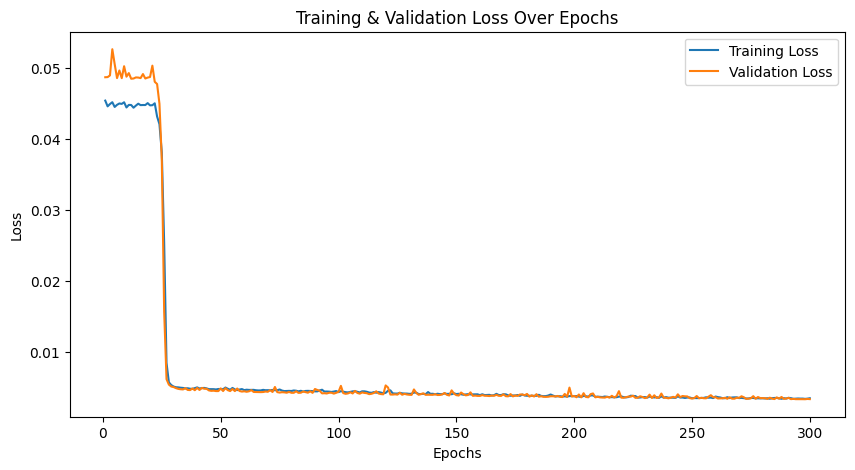


Calculating Permutation Feature Importance...


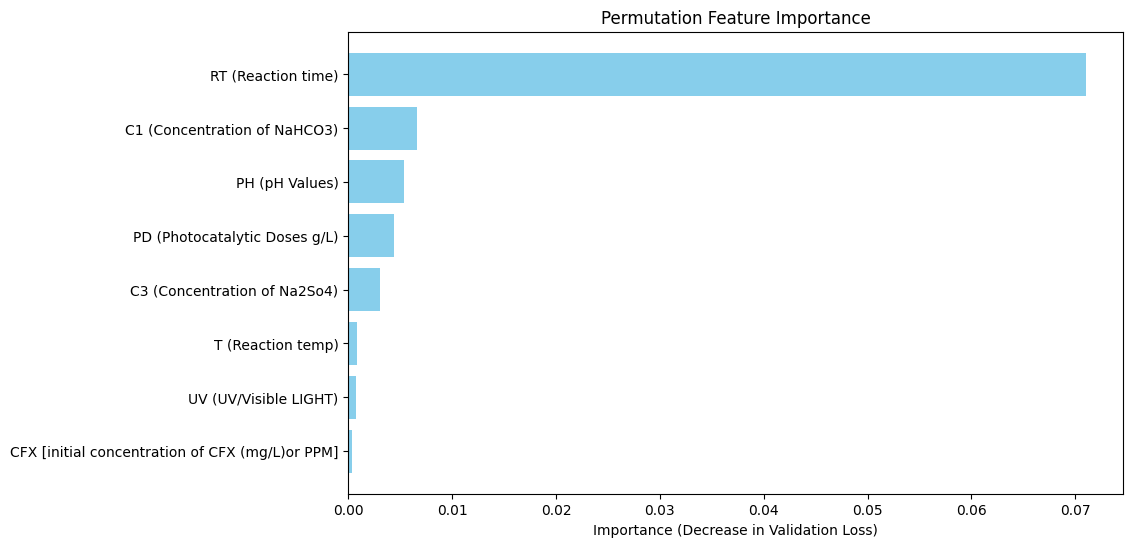

In [ ]:
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# Load dataset
url = './DataSet-Full (1).xlsx'
my_df = pd.read_excel(url)

# Feature selection
X = my_df.drop(['C (C/C0)', 'C2 (Concentration of NaCl)'], axis=1).values
Y = my_df['C (C/C0)'].values.reshape(-1, 1)

# Train-Validation-Test split
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Custom dataset class
class CefiximeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, i):
        return self.X[i], self.y[i]

# Dataloaders
train_dataset = CefiximeDataset(X_train, Y_train)
val_dataset = CefiximeDataset(X_val, Y_val)
test_dataset = CefiximeDataset(X_test, Y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Neural network definition
class Network(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(Network, self).__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_sizes[0])])
        for k in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[k], hidden_sizes[k+1]))
        self.output = nn.Linear(hidden_sizes[-1], output_size)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        for layer in self.hidden_layers:
            x = self.activation(layer(x))
        return self.output(x)

# Training function with early stopping
def train_model(model, dataloader, criterion, optimizer, device, n_epochs, val_X, val_Y):
    model.train()
    train_losses, val_losses = [], []
    best_loss = float('inf')
    patience, counter = 50, 0

    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for data, targets in dataloader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_loss = epoch_loss / len(dataloader)
        train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            val_pred = model(torch.tensor(val_X, dtype=torch.float32, device=device))
            val_loss = criterion(val_pred, torch.tensor(val_Y, dtype=torch.float32, device=device)).item()
            val_losses.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            break

    return train_losses, val_losses

# Validation/testing helper
def validate_model(model, X, Y, criterion, device, phase="Testing"):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
        Y_tensor = torch.tensor(Y, dtype=torch.float32, device=device)
        Y_pred = model(X_tensor)
        loss = criterion(Y_pred, Y_tensor).item()
    return loss, Y_pred.cpu().numpy()

# Grid search for best hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

param_grid = {
    'hidden_sizes': [
        [64, 64],
        [128, 128],
        [128, 128, 64],
        [128, 128, 128, 64, 64],
        [16,32,64,128,256]
    ],
    'learning_rate': [0.001, 0.0005, 0.0002],
    'weight_decay': [1e-4, 2e-5]
}

param_combinations = list(product(
    param_grid['hidden_sizes'],
    param_grid['learning_rate'],
    param_grid['weight_decay']
))

best_val_loss = float('inf')
best_model = None
best_params = None

print("\nStarting Grid Search...\n")
for idx, (hidden_sizes, lr, wd) in enumerate(param_combinations):
    print(f"Trying {idx+1}/{len(param_combinations)}: Hidden={hidden_sizes}, LR={lr}, WD={wd}")
    model = Network(input_size=X_train.shape[1], hidden_sizes=hidden_sizes, output_size=1).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.MSELoss()
    train_losses, val_losses = train_model(model, train_loader, criterion, optimizer, device, 300, X_val, Y_val)
    val_loss = val_losses[-1]
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_params = (hidden_sizes, lr, wd)

print(f"\nBest Parameters: Hidden={best_params[0]}, LR={best_params[1]}, WD={best_params[2]}")
print(f"Best Validation Loss: {best_val_loss:.4f}")

# Final Evaluation
val_loss, _ = validate_model(best_model, X_val, Y_val, nn.MSELoss(), device, phase="Validation")
test_loss, Y_pred = validate_model(best_model, X_test, Y_test, nn.MSELoss(), device, phase="Testing")

mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)

print(f"\nFinal Evaluation on Test Set:")
print(f"MSE = {mse:.4f}, R² = {r2:.4f}, MAE = {mae:.4f}")
# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.legend()
plt.show()


# Permutation Feature Importance
def permutation_importance(model, X_val, Y_val, criterion, device, feature_names):
    baseline_loss, _ = validate_model(model, X_val, Y_val, criterion, device)
    importances = []
    for i in range(X_val.shape[1]):
        X_val_permuted = X_val.copy()
        X_val_permuted[:, i] = np.random.permutation(X_val_permuted[:, i])
        permuted_loss, _ = validate_model(model, X_val_permuted, Y_val, criterion, device)
        importance = permuted_loss - baseline_loss
        importances.append(importance)
    return dict(zip(feature_names, importances))

feature_names = [col for col in my_df.columns if col not in ['C (C/C0)', 'C2 (Concentration of NaCl)']]
print("\nCalculating Permutation Feature Importance...")
feature_importances = permutation_importance(best_model, X_val, Y_val, nn.MSELoss(), device, feature_names)

# Plot Feature Importance
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
sorted_feature_names, sorted_importances = zip(*sorted_features)

plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
plt.xlabel('Importance (Decrease in Validation Loss)')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.show()
